# PyTorch Bootcamp

PyTorch provides many utilities around neural networks and deep learning, but at its very core it consists of two main features: GPU-accelerated linear algebra operations, and automatic differentiation.

Over the course of this tutorial, we will use the auto-diff feature to tune the control parameters of various signal processing algorithms using gradient descent. But first, let's get familiar with the basics of PyTorch.

## Tensors

Tensors are the basic data structure in PyTorch. They are similar to numpy arrays, but offer support for the two main features mentioned above. Let's create some tensors and look at some basic operations.

In [1]:
import torch

# Create a scalar (0D tensor)
scalar = torch.tensor(42) # watch the type - this is an integer, not a float
scalar = torch.tensor(42, dtype=torch.float32) # explicitly enforce float type
scalar = torch.tensor(42.) # or infer from built-in python float type
print("a =", scalar)

# Create a vector (1D tensor)
vector = torch.tensor([1., 2., 3.])
print("v =", vector)

# Create a matrix (2D tensor)
matrix = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
print("M =", matrix)

a = tensor(42.)
v = tensor([1., 2., 3.])
M = tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [2]:
# Element-wise addition and multiplication
print("v + v =", vector + vector)
print("v * v =", vector * vector)

v + v = tensor([2., 4., 6.])
v * v = tensor([1., 4., 9.])


In [3]:
# Broadcasting: Tensors are automatically expanded when doing element-wise operations
print("a * v =", scalar * vector)
print("M * v =", matrix * vector)

a * v = tensor([ 42.,  84., 126.])
M * v = tensor([[ 1.,  4.,  9.],
        [ 4., 10., 18.]])


In [4]:
# Matrix multiplication (dot product) uses the '@' operator
print("v @ v =", vector @ vector)
print("M @ v =", matrix @ vector)

v @ v = tensor(14.)
M @ v = tensor([14., 32.])


In [5]:
# Various mathematical operations can be applied element-wise
print("v^2 =", vector ** 2) 
print("exp(v) =", torch.exp(vector))
print("sin(v) =", torch.sin(vector))

v^2 = tensor([1., 4., 9.])
exp(v) = tensor([ 2.7183,  7.3891, 20.0855])
sin(v) = tensor([0.8415, 0.9093, 0.1411])


In [6]:
# Complex values are also supported
cmplx = torch.tensor([2., 3.], dtype=torch.complex64) # explicitly enforce complex type
cmplx = torch.tensor([2+3j, 4+5j]) # or infer from built-in python complex type

## Gradients and Auto-Differentiation

We are often interested in the values of tensors that minimize some objective function. This is where automatic differentiation comes in: if we know the gradient of a function with respect to its inputs, we know that adjusting the inputs in the opposite direction of the gradient will decrease the value of the function. This is called gradient descent optimization.

To let PyTorch know that we want to compute the gradient with respect to a certain tensor, we need to set the `requires_grad` flag. Let's take a look at what happens when we do this and perform operations on the tensor to calculate $z = \sin\left((w + 1)^3\right)$

In [7]:
w = torch.tensor(1., requires_grad=True)
x = w + 1
y = x ** 3
z = torch.sin(y)
print("w:", w)
print("x:", x)
print("y:", y)
print("z:", z)

w: tensor(1., requires_grad=True)
x: tensor(2., grad_fn=<AddBackward0>)
y: tensor(8., grad_fn=<PowBackward0>)
z: tensor(0.9894, grad_fn=<SinBackward0>)


Notice how every tensor now carries an attribute `grad_fn` that describes how to compute the gradient of the operation that it resulted from. Thanks to the chain rule of calculus, the calculation of the gradient of the final output $z$ with regard to the input $x$ can be decomposed into a product of these "local" gradients:

$$\frac{d z}{dw} = \frac{dz}{dy}\cdot\frac{dy}{dx}\cdot\frac{dx}{dw}$$

This is the essence of auto-differentiation. In the **forward pass**, PyTorch builds a computational graph of operations that know how to compute their gradients locally. In the **backward pass**, this graph is used to compute the gradient of the final output with respect to the initial inputs. The backward pass can be triggered by calling the `backward()` method on the final output. 

In [8]:
w = torch.tensor(1., requires_grad=True)
x = w + 1
y = x ** 3
z = torch.sin(y)
z.backward()
print("dz/dw evaluated at w=1:", w.grad)

dz/dw evaluated at w=1: tensor(-1.7460)


Although the final "output" function is usually a scalar, there can be multiple input tensors of arbitrary shape. In this case, the gradient of the output is computed with respect to each individual element of the input tensors.

In [9]:
M = torch.randn(3, 3, requires_grad=True)
v = torch.randn(3, requires_grad=True)
z = (M @ v).sum()
z.backward()
print(M.grad)
print(v.grad)

tensor([[ 2.2507, -0.6560,  1.3917],
        [ 2.2507, -0.6560,  1.3917],
        [ 2.2507, -0.6560,  1.3917]])
tensor([-0.8672, -1.5170, -1.5646])


Some things to keep in mind when using auto-differentiation in PyTorch:

- The gradients of "intermediate" tensors (`x` and `y` in the above example) are not stored by default. If we want to keep them, we need to mark them with `x.retain_grad()`, or use the `retain_graph=True` flag when calling `backward()`.
- Multiple calls to `backward()` will accumulate gradients in the leaf nodes, not overwrite them. If we want to re-calculate the gradients, we need to zero them out explicitly before.
- Not all operations support gradient propagation. This includes functions that are non-differentiable (e.g. `argmax`), or in-place modification of tensors (e.g. `x += 3` or `x[2] = 0`).

## Optimizers

Now that we know how to compute gradients, we can use them to find the parameters that minimize some objective function. In the most basic version of gradient descent, we update our estimate of parameters $x$ of a function $f$ according to the following rule:

$$ x \leftarrow x - \gamma \nabla_x f(x) $$

where $\nabla_x f(x)$ is the gradient of the function $f$ with respect to $x$, and $\gamma$ is some (typically small) learning rate. Note that the gradient points into the direction of steepest *ascent*, so we need to subtract it from $x$ to move in the direction of steepest *descent*, i.e. towards the minimum of $f$.

In PyTorch, this is encapsulated in optimizer objects. These objects take a list of parameters that we want to optimize, and provide a `step()` method that performs the above update rule. The most basic optimizer is the `SGD` optimizer, which implements the above rule in the default case. Other optimizers such as `Adam` or `RMSprop` use more sophisticated update rules that may converge faster or more reliably in some cases.

Let's work through a simple example and consider the function $f(x) = x^2 - 3x + 1$. We can find the gradient analytically as $\nabla_x f(x) = 2x - 3$ to see that the minimum of $f$ should be at $x = 3/2$. Let's see if we can find the same minimum using gradient descent and automatic differentiation.

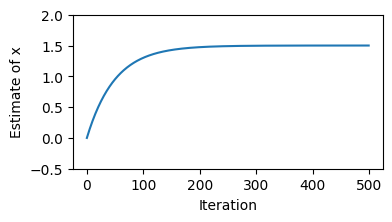

In [21]:

# Initial estimate
x = torch.tensor(0., requires_grad=True)

# Initialize optimizer with parameters to be optimized and learning rate
optim = torch.optim.SGD([x], lr=0.01)

# Number of iterations
n_iter = 500

xs = []

# Gradient descent loop
for i in range(n_iter):
    xs.append(x.item())
    
    f = x**2 - 3*x + 1 # forward pass
    f.backward() # backward pass
    
    # Perform the gradient descent step
    optim.step()
     
    # Reset the gradients
    optim.zero_grad()
    
# Plot how the estimate for x converged
from matplotlib import pyplot as plt
plt.figure(figsize=(4, 2))
plt.plot(xs)
plt.xlabel('Iteration')
plt.ylabel('Estimate of x')
plt.ylim([-0.5, 2])
plt.show()

It looks like our estimate is converging to the correct value of $3/2$. Of course, the sort of objective functions that we use in practice are a lot more complicated and provide additional challenges such as local minima, saddle points, and plateaus. But the basic principle of gradient descent optimization remains the same.

## Modules and Parameters

In PyTorch, objects that inherit from the `Module` class are used to encapsulate a computation that typically depends on some state saved in the module. Modules can be used to represent neural network layers, but also other functions that we want to optimize. The computation is defined in the `forward()` method. 

The `Parameter` class is a special type of tensor that has `requires_grad=True` by default. Parameters   The `Module` class provides some helpful utility methods to obtain all `Parameter`s that were assigned as to it an attribute. 

For example, a simple linear regression model of the form $y = w x + b$ can be implemented as follows:

In [17]:
class MyLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # initialize parameters randomly from a uniform distribution on the interval [-1, 1]
        self.w = torch.nn.Parameter(2 * torch.rand(1) - 1)
        self.b = torch.nn.Parameter(2 * torch.rand(1) - 2)
        
    def forward(self, x):
        return self.w * x + self.b
    
model = MyLinearModel()
for p in model.named_parameters():
    print(p)

('w', Parameter containing:
tensor([-0.2081], requires_grad=True))
('b', Parameter containing:
tensor([-1.4673], requires_grad=True))


Putting it all together, we can now use the `SGD` optimizer to find the parameters of our linear model that minimize the mean squared error between the model predictions and some noisy observations. The auto-differentiation takes care for us of computing the gradient of the loss function with respect to the model parameters, and the optimizer updates the parameters in the direction of steepest descent.

In [18]:
# Create a noisy dataset along the line y = 2x + 1
n_points = 100
x = torch.rand(n_points)
y = 2 * x + 1 + 0.3 * torch.randn(n_points)

# Fit a linear model to the data
model = MyLinearModel()

print("Initial parameters:")
print("w =", model.w.item())
print("b =", model.b.item())
print()

optim = torch.optim.SGD(model.parameters(), lr=0.01)
n_iter = 2000

mse_loss = torch.nn.MSELoss()

ws = []
bs = []

for i in range(n_iter):
    ws.append(model.w.item())
    bs.append(model.b.item())
    
    optim.zero_grad()
    
    # forward pass
    y_pred = model(x)
    loss = mse_loss(y_pred, y)
    
    # backward pass
    loss.backward()
    
    # gradient descent step 
    optim.step()

print("Parameters after fitting:")
print("w =", ws[-1])
print("b =", bs[-1])

Initial parameters:
w = -0.7926058769226074
b = -0.3540135622024536

Parameters after fitting:
w = 1.9811313152313232
b = 0.9794144630432129


In [19]:
# Animate the fitting process

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [], lw=2, color='red')
ax.scatter(x, y)
ax.set_xlabel("X")
ax.set_ylabel("Y")

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, ws[i * 10] * x + bs[i * 10])
    ax.set_title(f"Estimated fit after {i * 10} iterations")
    return line,

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=len(ws) // 10, interval=50, blit=True)
plt.close(fig)
display(HTML(anim.to_html5_video()))
